In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# package
import os
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import xarray as xr
import sys
import datetime
import pandas as pd
# script
from ncdf_io import ncdf_io
from regression import regress
from time_convert import time_convert, tarray_month

### Greenland mass load 

In [3]:
dir1='/Users/joedhsu/Research/Rsync/Data_p/GRACE05_CSR/004_154/Greenland/'
file1='lmass.t60.s300.m.deg1.com004_154.GERUO_ICE5_COMP.ptcorr.nc'
file2='lmass.t60.s300.m.deg1.scaMB_decom_multi.com004_154.GERUO_ICE5_COMP.ptcorr.nc'
file3='slf.t60.s300.m.deg1.scaMB_decom_multi.com004_154.GERUO_ICE5_COMP.ptcorr.rf.nc'
files=[file1]
outfile=['gisnoscale.nc','gisscale.nc','gisslf.nc']

dir2='/Users/joedhsu/Research/Rsync/Data/Mask/Land_mask_v4/'
mfile2='land.fcn.1x1.1.0_deg_100KM2min_modi_greenland.nc'

In [23]:
# read file 
gism=ncdf_io(dir2+mfile2,verbose=0)
dsm=gism.read_ncdf2xarray()

for i in range(len(files)): 
    
    # change the original axis from numpy array to pd.index
    gis=ncdf_io(dir1+files[i],verbose=0)
    ds=gis.read_ncdf2xarray()

    # old time stamp (change from np.array to pd.index)
    gmonth=np.array(ds['time'])+1   # start from 0 
    tdict=time_convert(gmonth).gmonth2year_mon()
    year=tdict['year']
    month=tdict['month']
    tstamp=pd.to_datetime([datetime.datetime(year[ii],month[ii],15) for ii in range(len(year))])

    # assign new time stamp
    ds['time']=xr.DataArray(tstamp,coords=[tstamp],dims=['time'])

    # masking the data 
    mask=dsm['z'].where(dsm>1E-10)['z']    # xr.Dataset to xr.Array
    ldata=ds['z']                          # xr.Dataset to xr.Array
    ldata=ldata*mask
    
    # make time array based on timestamp
    yeardate=time_convert(ds.time).tarray_month2year()

    # regression
    ds=xr.Dataset()   
    reg=regress(axis=yeardate)
    dict1=reg.multivar_regress(np.array(ldata.isel(lon=0,lat=0))
                                      ,predef_var='semisea_sea_lin')
    dimname=reg.dm_order # new dim 
    beta=np.zeros([ldata.lon.shape[0],ldata.lat.shape[0],len(dimname)])+np.nan
    se=np.zeros([ldata.lon.shape[0],ldata.lat.shape[0],len(dimname)])+np.nan   
    for ii in range(len(ldata.lon)):
        for jj in range(len(ldata.lat)):
            if ~ldata.isel(lon=ii,lat=jj).sum(dim='time',skipna=False).isnull():
                dict1=reg.multivar_regress(np.array(ldata.isel(lon=ii,lat=jj))
                                          ,predef_var='semisea_sea_lin')
                beta[ii,jj,:]=dict1['beta']
                se[ii,jj,:]=dict1['se']


            

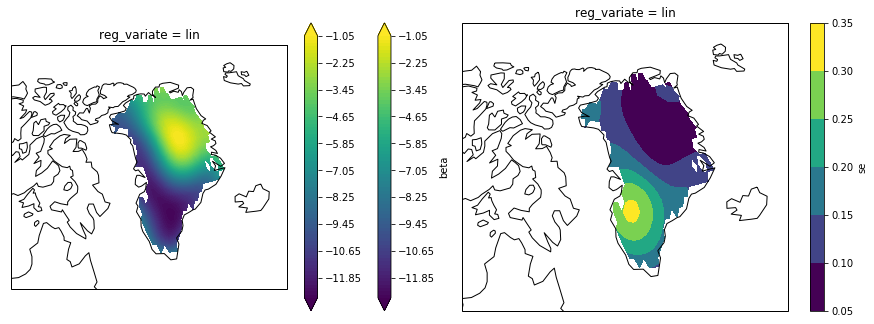

In [60]:
xr_beta=xr.DataArray(beta, coords=[ldata.lon,ldata.lat,dimname], 
                             dims=['lon','lat','reg_variate'])
xr_se=xr.DataArray(se, coords=[ldata.lon,ldata.lat,dimname], 
                     dims=['lon','lat','reg_variate'])
xr_beta=xr_beta.T  # for plotting must be lat lon
xr_se=xr_se.T
ds['beta']=xr_beta
ds['se']=xr_se     
ds.to_netcdf('./data/regress_'+outfile[i])
# plot the data
data_proj=ccrs.PlateCarree()
fig_proj=ccrs.Orthographic(-50, 45)    # rotating the center of the projection

fig=plt.figure()
ax1=fig.add_axes([0,0,1,1],projection=fig_proj)
plot1=ds['beta'].sel(reg_variate='lin').plot.contourf(ax=ax1, transform=data_proj
                                                , levels=100, extend='both',cmap='viridis')
plt.colorbar(plot1)
ax2=fig.add_axes([1,0,1,1],projection=fig_proj)
ds['se'].sel(reg_variate='lin').plot.contourf(ax=ax2, transform=data_proj)

# data2.plot.contourf(ax=ax2, transform=data_proj)
# # plt.colorbar(ct1,ax=ax1,extend='both')
ax1.set_extent([280,340,55,90], crs=data_proj)
ax2.set_extent([280,340,55,90], crs=data_proj)
ax1.coastlines()
ax2.coastlines()


In [59]:
plot1

In [7]:
~ldata.isel(lon=0,lat=0).sum(dim='time',skipna=False).isnull()

<xarray.DataArray 'z' ()>
array(False)
Coordinates:
    lat      float32 90.0
    lon      float32 0.0

In [8]:
ds.time.dt.year

AttributeError: 'Dataset' object has no attribute 'time'

In [ ]:
data.plot.contourf()

In [ ]:
ds['z'].sel(time='2002-04-15').squeeze('time')



### Greenland sea level fingerprint

In [ ]:
ds['lon']

In [ ]:
file2='lmass.t60.s300.m.deg1.scaMB_decom_multi.com004_154.GERUO_ICE5_COMP.ptcorr.nc'
file3='slf.t60.s300.m.deg1.scaMB_decom_multi.com004_154.GERUO_ICE5_COMP.ptcorr.rf.nc'

In [ ]:

ax = plt.axes(projection=ccrs.Orthographic(-180, -90))
ds['z'].sel(time=3).plot.contourf(ax=ax, transform=ccrs.PlateCarree());
ax.set_global(); ax.coastlines();